# Data Preprocessing

In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import time

client = Client()
client

Client Scheduler: tcp://127.0.0.1:41709 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.01 GB


## Convert Dataset Type ##
Convert bus CSV data to Parquet for more efficient operations on raw data

In [ ]:
df = dd.read_csv('./../data/mobility/bus_data.csv')
dd.to_parquet(df, './../data/mobility/bus_data.parquet', engine='pyarrow')

In [ ]:
!pwd
!ls ./../data/mobility/bus_data.parquet/

## Create 'timestamp' Index Column ##
Read the Parquet files back lazily as Dask.DataFrame and make a 'timestamp' column

In [2]:
df = dd.read_parquet('./../data/mobility/bus_data.parquet', engine='pyarrow')
df['timestamp'] = dd.to_datetime(df['date'] + ' ' + df['time'])
df

,date,time,order,line,latitude,longitude,speed,timestamp
npartitions=199,,,,,,,,
,object,object,object,object,float64,float64,float64,datetime64[ns]
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


## Numify 'order' and 'line' ##
Find unique bus route names and bus license plate numbers and write them to a CSV file

In [ ]:
orders = df['order'].unique()
lines = df['line'].unique()

In [ ]:
orders.to_csv('./../data/mobility/orders.csv')
lines.to_csv('./../data/mobility/lines.csv')

Bring 'orders' and 'lines' sets back in the workspace as lists

In [3]:
orders_csv = dd.read_csv('./../data/mobility/orders.csv/0.part').compute()
lines_csv = dd.read_csv('./../data/mobility/lines.csv/0.part').compute()

orders = orders_csv['order'].values.tolist()
lines = lines_csv['line'].values.tolist()

Map element-wise the Dask.DataFrame of bus data to numify order/line information

In [4]:
df_new = df[['timestamp','order','line','latitude','longitude','speed']]
df_new['order'] = df['order'].map(lambda x: orders.index(x), meta=('order','int'))
df_new['line'] = df['line'].map(lambda x: lines.index(x), meta=('line','int'))

Write the transformed data into a parquet file

In [ ]:
dd.to_parquet(df_new, './../data/mobility/bus_data_clean.parquet', engine='pyarrow')

Remove no longer needed variables from the workspace to free up memory

In [ ]:
del orders, lines, orders_csv, lines_csv, df_new, df

## Cleaned Data ##
Shapefile has a singly-linked list structure, while .shx has an array structure: each row entry of both correspond to the same record

```fiona``` takes advantage of the .shx accompanying file to offset into the binary .shp without parsing the entire set row-by-row 

```GeoPandas``` wraps ```fiona``` in its ```geopandas.read_file()``` producing an in-memory ```GeoDataFrame```

In [7]:
from dask.distributed import Client
import dask.dataframe as dd

client = Client()
client

Client Scheduler: tcp://127.0.0.1:45157 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.01 GB


In [4]:
import geopandas
import dask_geopandas
from dask.delayed import delayed
from shapely.geometry import LineString, Polygon, box
from shapely import wkb

Using ```Dask and GeoPandas```, read in ESRI Shapefile in partitions and construct a Dask Dataframe out of it, according to a neat prototype of Joris [geopandas/dask-geopandas#11](https://github.com/geopandas/dask-geopandas/issues/11#issue-638156319)

In [37]:
def read_file(path, npartitions):
    
    with fiona.open(path) as collection:
        total_size = collection.session.get_length()
    
    # TODO smart inference for a good default partition size
    batch_size = (total_size // npartitions) + 1
    
    row_offset = 0
    dfs = []
    
    while row_offset < total_size:
        rows = slice(row_offset, min(row_offset + batch_size, total_size))
        df = delayed(geopandas.read_file)(path, rows=rows)
        df1 = delayed(df.to_crs)(3857)
        dfs.append(df1)
        row_offset += batch_size
    
    # TODO this could be inferred from fiona's collection.meta["schema"]
    meta = geopandas.read_file(path, rows=5)
    
    return dd.from_delayed(dfs, meta)

```dask-geopandas``` manages the interpretation of the produced Dask GeoDataFrame and writes ```Shapely``` geometry as bytes for the later consumption

In [40]:
gdf = read_file('./../data/osm_roads/gis_osm_roads_free_1.shp', 24)
ddf = dask_geopandas.from_dask_dataframe(gdf)
ddf

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
npartitions=24,,,,,,,,,,,
,object,int64,object,object,object,object,int64,int64,object,object,geometry
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [41]:
ddf.to_parquet('./../data/osm_roads/roads.parquet')

For efficient geospatial queries of the road network dataset, R\*-tree is employed. It facilitates retreival of entries corresponding to the space of interest with complexity: ![](https://latex.codecogs.com/svg.latex?O(\log_M%20N))

The R\*-tree is composed of roads' bounding boxes, hence another step of processing of the converted Parquet data is required to precalculate it and clean up boolean and integer data from the original GEOFABRIK data

In [ ]:
import pandas as pd

def speed_limit(limit, code):
    if limit == 0:
        if code in [5141, 5142, 5143, 5144, 5145, 5146, 5147]: # Track/access roads, typically gravel or field
            return 10
        elif code in [5121, 5122, 5123, 5133, 5134, 5135]: # Minor roads and their links
            return 30
        elif code in [5113, 5114, 5115, 5131, 5132]: # Primary roads, their links and links of major highways
            return 60
        elif code in [5112]: # Urban highway
            return 80
        elif code in [5111]: # Suburban highway
            return 110
        else:
            return 0
    else:
        return limit

df = dd.read_parquet('./../data/osm_roads/roads.parquet', engine='pyarrow')

meta = {
    'bbox':'bytes',
    'oneway':'bool',
    'bridge':'bool',
    'tunnel':'bool',
    'geometry':'bytes',
    'maxspeed':'int'
}

index = [
    'bbox',
    'oneway',
    'bridge',
    'tunnel',
    'geometry',
    'maxspeed'
]

df[['bbox','oneway','bridge','tunnel','geometry','maxspeed']] = df.apply(
    lambda x: pd.Series([
        box(*wkb.loads(x.geometry).bounds).wkb,
        x.oneway != 'B',
        x.bridge == 'T',
        x.tunnel == 'T',
        LineString(wkb.loads(x.geometry).coords[:].reverse()).wkb if x.oneway == 'T' else x.geometry,
        speed_limit(x.maxspeed, x.code)
    ], index=index),
    axis=1,
    meta=meta)

df = df.astype({'osm_id':'int'})
df2 = df[df.maxspeed > 0].set_index('osm_id')

In [ ]:
dd.to_parquet(df2, './../data/osm_roads/roads_new.parquet', engine='pyarrow')

In [8]:
df = dd.read_parquet('./../data/osm_roads/roads_new.parquet', engine='pyarrow')
df.head()

,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,bbox
osm_id,,,,,,,,,,,
4217292,5122,residential,Rua Vinícius de Moraes,None,True,30,0,False,False,b'\x01\x02\x00\x00\x00\r\x00\x00\x00``\xe1\xf0...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
4217293,5122,residential,Rua Joana Angélica,None,True,30,0,False,False,b'\x01\x02\x00\x00\x00\x13\x00\x00\x00\xc8\x99...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
4217294,5122,residential,Rua Farme de Amoedo,None,False,30,0,False,False,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xde\x00...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
4217295,5122,residential,Rua Teixeira de Melo,None,True,30,0,False,False,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\x1255\x...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
4217297,5122,residential,Rua Maria Quitéria,None,True,30,0,False,False,"b""\x01\x02\x00\x00\x00\x10\x00\x00\x00\x8fP\x9...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...


Now the data is in the ideal form to construct the R\*-tree and shuffle the data in the ```DataFrame``` accordingly. First the R\*-tree is bulk loaded top-down according to the [OMT method](http://ftp.informatik.rwth-aachen.de/Publications/CEUR-WS/Vol-74/files/FORUM_18.pdf)

However, for the sake of time, the custom dask-friendly OMT implementation is postponed and instead the functionality of ```libspatialindex``` Python wheel ```rtree``` is taken advantage of. It generates a separate index data structure out of the unique integer indices and bounding boxes that are provided to it. The resulting R-tree can later be queried using a bounding box of interest in which case it returns integer IDs intersecting the area of interest

To efficiently and trivially seek the Dask Dataframe entries, the ```osm_id``` is passed as the identifier for each bounding box upon R-tree entry insertion, which can then be directly used to index into the out-of-core dataframe. It is important that before insertion, the street segment coordinates be projected into the same CRS as the one used for the Dask Dataframe entries.

In [45]:
import pyproj
from shapely.geometry import LineString, Polygon, Point, box
from shapely.ops import transform
from shapely import wkb
import fiona
import rtree
import time
import numpy as np
import pandas as pd
import networkx as nx

In [18]:
%%time

wgs84 = pyproj.CRS('EPSG:4326')
pseudo_mercator = pyproj.CRS('EPSG:3857')

project = pyproj.Transformer.from_crs(wgs84, pseudo_mercator, always_xy=True).transform

with fiona.open('./../data/osm_roads/gis_osm_roads_free_1.shp') as layer_roads:
    index = rtree.index.Rtree('roads')

    for entry in layer_roads:
        if entry['properties']['code'] in [5141, 5142, 5143, 5144, 5145, 5146, 5147, 5121, 5122, 5123, 5133, 5134, 5135, 5113, 5114, 5115, 5131, 5132, 5112, 5111]:
            line = transform(project, LineString(entry['geometry']['coordinates']))
            osm_id = int(entry['properties']['osm_id'])
            index.insert(osm_id, line.bounds)

CPU times: user 18min 57s, sys: 44.2 s, total: 19min 41s
Wall time: 18min 37s


Once the index is constructed, it is serialized to disk and can be later retreived again using the same ```rtree.index.Rtree('rtree_name')``` constructor. To verify that the index is correct, list length of the index intersection with its own bounds can be performed. It returns the same number of entries as the original shapefile using ```len(fiona.open(filename.shp))```

In fact, since non-routable roads like pedestrian-only, bridleways, footways, cycleways, etc. were filtered out in the step above, the R-tree index is smaller than the original shapefile from GEOFABRIK by 89'433 entries

In [8]:
layer_roads = fiona.open('./../data/osm_roads/gis_osm_roads_free_1.shp')
print(len(layer_roads) - index.count(index.bounds))
layer_roads.close()

89433


Using ```rasterio``` reproject GeoTIFF Digital Elevation Model raster files from EPSG:4326 to EPSG:3857 coordinate system. This can however be done only after merging together rasters since after transformation of each tile, their sizes would no longer be equal

However, to ensure the DEM GeoTIFF contains data for each road data point, it is necessary to find boundaries of the R-tree and preload raster tiles from AW3D30 for the area of interest

In [29]:
import rtree
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
index = rtree.index.Rtree('roads')

print(
    f"Left bottom corner: {tuple(zip(('lon','lat'),transformer.transform(index.bounds[0],index.bounds[1])))[::-1]}\n"
    f"Right top corner: {tuple(zip(('lon','lat'),transformer.transform(index.bounds[2],index.bounds[3])))[::-1]}")

Left bottom corner: (('lat', -25.237743800000004), ('lon', -53.1848493))
Right top corner: (('lat', -14.178782400000003), ('lon', -39.6346888))


Now knowing the bounding box of the R-tree in WGS84, it is straightforward to logon the website and download all the non-empty tiles before proceeding with the next steps

In [1]:
from dask.distributed import Client, as_completed, get_client
import dask.dataframe as dd
from shapely.geometry import LineString, Polygon, Point, box
from shapely import wkb
import rtree
import time
import copy
import pandas as pd
import networkx as nx
import rasterio
from rasterio.plot import show

# client = Client(memory_limit='4GB')
# client = Client()
# client

In [26]:
from osgeo import gdal
import pprint
import os
from rasterio.transform import Affine
import re
import numpy as np

First, to merge tiles there must be an equal number of sub-tiles in each future row, each with its own ```Affine``` transformation matrix - simply said, it is needed to zero pad data to a rectangle. Hence as the first step, for spatial sectors with no elevation data (that being sea) it is required to fill with zeros

In [34]:
files = []
for i in range(15,27):
    for k in range(40,55):
        files.append('S0'+str(i)+'W0'+str(k))

Z = np.zeros((dataset.height, dataset.width), dtype=np.int16)
data_files = os.listdir('./../data/aw3d30_elevation')

for file in files: 
    if file not in data_files:
        s = re.findall('[0-9]{3}', file)
        
        os.mkdir('./../data/aw3d30_elevation/'+file)
        
        dataset = rasterio.open(
            './../data/aw3d30_elevation/'+file+'/ALPSMLC30_'+file+'_DSM.tif',
            'w',
            driver='GTiff',
            height=Z.shape[0],
            width=Z.shape[1],
            count=1,
            dtype=Z.dtype,
            crs='+proj=latlong',
            transform=Affine(0.0002777777777777778, 0.0, -float(s[1]), 0.0, -0.0002777777777777778, -float(s[0])),
        )

        dataset.write(Z, 1)
        dataset.close()

Once a sub-tile for every sector of the future rectangular tile is constructed, the mosaic is passed to ```GDAL``` CLI for merge, which performs merge on-disk

In [40]:
%%time
dem_list = ['./../data/aw3d30_elevation/'+file+'/ALPSMLC30_'+file+'_DSM.tif' for file in os.listdir('./../data/aw3d30_elevation')]
dem_list.sort()

cmd = 'gdal_merge.py -o ./../data/elevation/mergedDEM.tif ' + ' '.join(dem_list)
os.system(cmd)

CPU times: user 12.5 ms, sys: 6.29 ms, total: 18.8 ms
Wall time: 3min 50s


0

The DEM is now merged. Next step is to reproject it to a different CRS, namely EPSG:3857, which is again done on disk

In [41]:
%%time
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:3857'

with rasterio.open('./../data/elevation/mergedDEM.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('./../data/elevation/mergedReprojDEM.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

CPU times: user 2min 55s, sys: 3min 48s, total: 6min 43s
Wall time: 12min 38s


The resulting GeoTIFF of the region is too large and cannot be plotted at once unless ```Bokeh``` or some other lazy loading interactive visualization library is used, but some basic details of the DEM can be trivially reported for verification of the success of the above steps

In [43]:
dataset = rasterio.open('./../data/elevation/mergedReprojDEM.tif')

pprint.pprint({
    'crs': dataset.crs,
    'transform': dataset.transform,
    'width': dataset.width,
    'height': dataset.height,
    'bounds': dataset.bounds
})

dataset.close()

{'bounds': BoundingBox(left=-6011252.502836776, bottom=-3805241.9650874436, right=-3589996.0766833476, top=-1574216.5481614613),
 'crs': CRS.from_epsg(3857),
 'height': 69371,
 'transform': Affine(32.16077924386245, 0.0, -6011252.502836776,
       0.0, -32.16077924386245, -1574216.5481614613),
 'width': 75286}


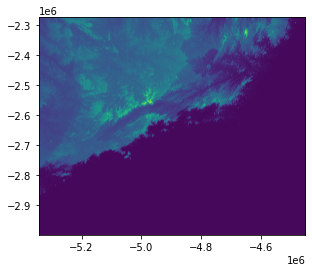

<AxesSubplot:>

In [2]:
# TODO: use Bokeh to interactively lazily display the DEM

# show(dataset.read(), transform=dataset.transform)

The next step is to aggregate these data sources and fetch all the necessary data into the roads Dask Dataframe for an efficient row-wise ```apply()``` operation to construct the road network Graph

In [2]:
import xarray as xr

index_url = './../data/roads'
df_url = './../data/osm_roads/roads_new.parquet'
dataset_url = './../data/elevation/mergedReprojDEM.tif'

index = rtree.index.Rtree(index_url)
df = dd.read_parquet(df_url, engine='pyarrow')
dem = xr.open_rasterio(dataset_url, chunks={'band':1, 'x': 3500, 'y': 4000})
dem

,Array,Chunk
Bytes,10.45 GB,28.00 MB
Shape,"(1, 69371, 75286)","(1, 4000, 3500)"
Count,397 Tasks,396 Chunks
Type,int16,numpy.ndarray


### Road Network Graph Building ###

Regardless of use of sequential or paralle approach, the source for processing each road entry is universal

The set of functions is applied to each Dask Dataframe row of the input roads parquet dataset and a new Dask Dataframe of nodes and edges, for Parallel approach, or a single Graph, for Sequential approach, is returned. In case of the former, an additional reduction step is later performed to construct a Graph out of the newly obtained data. The final result of either approach is a road network weighted multidirectional Graph

As mentioned prior, ```MultiDiGraph``` is a directional NetworkX graph with more than 1 link between any 2 nodes, just what is required to model the desired road network: its use allows to recreate the street traffic flow rules for oneway and twoway streets. The graph is constructed by iterating over Dask Dataframe and loading weighted edges with multiple attributes into the graph. The set of attributes for each edge are - length, duration, and flatness. All 3 are the link metrics to choose from when performing routing algorithms like shortest path or multi-criteria routing. Missing node attributes for completeness are later added as well for label-based search

The logical flow: workflow maps every Dask Dataframe road entry into a list of street intersections/junctions (nodes) and weighted multi-parameter links between them (edges). It uses R-Tree spatial index generated in the previous steps to obtain the list of osm_id's whose bounding boxes spatially intersect the bounding box of the road the dataset is tested against

The resulted handful of osm_id's are used for constant-time trivial retrieval of the corresponding 'neighbor' entries from the Dask Dataframe to test for actual intersection. Those fulfilling this and severalother conditions compose the list of nodes and edges, which are later be fed into the NetworkX graph construction functions 

All this constructs a MultiDiGraph of the road network with multiple edge attributes for multi-criteria routing. Topological information can be inferred from the unhashed node values, which are the spatial coordinates of each node, for convenient plotting on a map for verification and/or visualization

In [3]:
def get_neighbors(index, row):
    # Query R-Tree by the bounding box of road 'x' for neighbors except itself
    return [int(i) for i in index.intersection(wkb.loads(row.bbox).bounds) if int(i) != row.Index]


def find_intersections(neighbors, row):
    intersections = [] # Container for street intersections    
    nodes = [] # Arrays of tuples for NetworkX MultiDiGraph
    a = wkb.loads(row.geometry)
    road = a.coords[:]
    
    for entry in neighbors.itertuples():
        b = wkb.loads(entry.geometry)
        if not (entry.bridge or entry.tunnel) and a.intersects(b): # Check if road with 'fid' osm_id actually intersects road 'x'
            pts = a.intersection(b)
            if pts.type == 'MultiPoint':
                (nodes.append((pt.coords[:][0], {'junction':[row.Index, entry.Index]})) for pt in pts)
                (intersections.append(pt) for pt in pts if pt.coords[:][0] != road[0] and pt.coords[:][0] != road[-1] and (pt.coords[:][0] not in intersections))
            elif pts.type == 'Point':
                nodes.append((pts.coords[:][0], {'junction':[row.Index, entry.Index]}))
                if pts.coords[:][0] != road[0] and pts.coords[:][0] != road[-1] and (pts.coords[:][0] not in intersections):
                    intersections.append(pts)
    
    [nodes.append((pt, {'junction':[row.Index]})) for pt in [road[0], road[-1]] if not nodes or pt not in tuple(zip(*nodes))[0]]

    return nodes, intersections


def get_elevation(nodes, a, dem):
    b = [pt[0] for pt in nodes] # List coordinates of graph nodes (permits duplication)
    
    data = dem[tuple([[0]]+list(map(list,zip(*((round((pt[0]-dem.transform[2])/dem.transform[0]), round((pt[1]-dem.transform[5])/dem.transform[4])) for pt in a+b)))))].data[0].compute() # Retrieve elevations for road points and graph nodes
    
    road_elevations = [data[i][i] for i in range(len(a))] # The first 'a' elements correspond to road points
    
    for i in range(len(b)):
        nodes[i][1]['altitude'] = data[len(a)+i][len(a)+i] # The second 'b' elements correspond to graph nodes
    
    return nodes, road_elevations


def compute_edges(intersections, nodes, road_elevations, row):
    road = wkb.loads(row.geometry).coords[:]
    edges = []
    segment_len = 0
    segment_flatness = 0
    previous_node_elevation = road_elevations[0]
    previous_node = road[0] # Coordinate keeping track of previous intersection/edge end

    for idx in range(len(road)-1):
        segment = LineString(road[idx:idx+2]) # LineString of straight line segment between two consecutive points
        segment_start = road[idx] # Coordinate updating on every segment or when intersection encountered
        queue = [] # Point objects that intersect this particular road straight line segment

        for pt in list(intersections):
            if segment.intersects(pt):
                queue.append(pt) # Put all junctions intersecting this segment into a queue
                intersections.remove(pt) # Remove the junction from left-over list of street intersections

        if not queue:
            segment_len += segment.length # If no junctions in this road segment, increase length by distance between LineString consecutive points
            next_node_elevation = road_elevations[idx+1]
            segment_flatness += (previous_node_elevation - next_node_elevation) ** 2 
            previous_node_elevation = next_node_elevation
        else:
            for pt in list(queue):
                line_lengths = [LineString([segment_start, p.coords[:][0]]).length for p in queue]
                shortest_line = min(line_lengths)
                next_node_idx = [k for k, l in enumerate(line_lengths) if l == shortest_line][0]
                next_node = queue[next_node_idx].coords[:][0]
                segment_len += LineString([segment_start, next_node]).length

                if segment_len: # Multiple roads crossing at the same junction. Can skip. osm_id's on intersectinos are maintained by nodes array
                    next_node_elevation = [node[1]['altitude'] for node in nodes if node[0] == next_node][0]
                    segment_flatness += (previous_node_elevation - next_node_elevation) ** 2 
                    previous_node_elevation = next_node_elevation

                    edges.append((
                        previous_node,
                        next_node,
                        {
                            'length':segment_len,
                            'weight':segment_len/row.maxspeed/1000,
                            'flatness':segment_flatness/segment_len
                        }))

                    if not row.oneway: # If both way street, add identical reverse relation between MultiDiGraph nodes
                        edges.append((
                            next_node,
                            previous_node,                          
                            {
                                'length':segment_len,
                                'weight':segment_len/row.maxspeed/1000,
                                'flatness':segment_flatness/segment_len
                            }))

                segment_len = 0
                segment_flatness = 0
                previous_node = next_node
                segment_start = next_node
                queue.remove(queue[next_node_idx]) # Remove the junction from the queue

            segment_len += LineString([segment_start, road[idx+1]]).length # Get distance to the endpoint of the segment
            next_node_elevation = road_elevations[idx+1]
            segment_flatness += (previous_node_elevation - next_node_elevation) ** 2 
            previous_node_elevation = next_node_elevation

    edges.append((
        previous_node,
        road[-1],
        {
            'length':segment_len,
            'weight':segment_len/row.maxspeed/1000,
            'flatness':segment_flatness/segment_len
        }))

    if not row.oneway: # If both way street, add identical reverse relation between MultiDiGraph nodes
        edges.append((
            road[-1],
            previous_node,            
            {
                'length':segment_len,
                'weight':segment_len/row.maxspeed/1000,
                'flatness':segment_flatness/segment_len
            }))
        
    return edges

#### Parallelized Graph Building Approach ####

Sequential processing throughput is ~3'700 roads/hour. For the region of 2M+ roads, such compute on the author's old laptop would take ~539 hours. Although different Numba optimizations could be done to enhance performance by x1000 and run the job locally, learning and implementing on top of the time consuming progress thus far is overwhelming and might not be feasible in the remaining timeframe despite being a very attractive improvement

This processing step was scaled to the cluster since the task graph requires distributing the 12GB+ of DEM and roads data across workers prior to feeding each road entry into this graph for parallel computation. The author's RAM is 4GB, the remaining is served from SWAP, which is thousands times slower, hence it is not possible to process this particular task graph on the device, yet. Configuration of 3 Skylake nodes on the Genius HPC for a total of 5 hours was used, with a total cost of 150 credits

An alternative would be to split the roads data into N partitions and run that on N local processes (where N processes is the 4 hardware threads on the author's laptop) while passing the entire Dask Dataframe as input to each process: hence each process would be running the sequential code below, but each will only have to process 1/4th of the input set

**TODO: update text after processing on VSC**

Using dd.apply() caused serialization/pickling errors: partition mapping approach was attempted instead. This effectively splits task into 24 parallel tasks (equal to #partitions of the roads Dask Dataframe). However, beacuse ```find_intersections``` envokes ```compute()``` on DEM Dask XArray and roads Dask Dataframe, the scheduler becomes overwhelmed with the increasing number of tasks asking to acquire read/write locks to the data as Dask starts a new task for nearly every indexing operation and utilizes only 10% of CPU. Hence it suffocates itself. It was chosen to follow the sequential approach instead to avoid this bottleneck for this seemingly trivially parallelizable task

In [ ]:
%%time

def foo(row, df, dem, index_url):
    fids = []
    
    # Assumption that bridges and tunnels do not have intersections
    if not (row.bridge or row.tunnel): 
        index = rtree.index.Rtree(index_url)
        
        # Retreive from R-tree osm_id's of roads whose bounding box overlaps this road's
        fids = get_neighbors(index, row)
    else:
        # If bridge or tunnel, only intersects others at start/end of way
        fids = [] 

    # Retreive those roads from the dataset by indexing
    neighbors = df.loc[fids].compute()

    # Build up list of Graph nodes and list of intersections
    (nodes, intersections) = find_intersections(neighbors, row)

    # Retrieves elevation data for all road points and graph nodes
    (nodes, road_elevations) = get_elevation(nodes, wkb.loads(row.geometry).coords[:], dem)

    # Calculate graph edges between junction nodes
    edges = compute_edges(intersections, nodes, road_elevations, row)

    return nodes, edges


# df[['nodes','edges']] = df.apply( # Process full set
df2 = df.loc[4217292:4331539].apply( # Process first 100 roads
    foo, 
    args=(df, dem, index_url), 
    axis=1, 
    result_type='expand', 
    meta={0:'object',1:'object'})

# dd.to_parquet(df, './../data/osm_roads/nodes_edges.parquet', engine='pyarrow') # Process full set
dd.to_parquet(df2, './../data/osm_roads/nodes_edges.parquet', engine='pyarrow') # Process first 100 roads

After this step, the processed data was pulled from the cluster back into local Jupyter session into the corresponding directory and used in the following reduction step to construct the actual road network multidirectional weighted Graph

In [ ]:
%%time

df = dd.read_parquet('./../data/osm_roads/nodes_edges.parquet', engine='pyarrow')

# Reduce futures to a NetworkX Graph as they arrive back with results
G = nx.MultiDiGraph()

for row in df.itertuples():
    if row.nodes and row.edges:
        G.add_edges_from(row.edges) # Creates nodes if they do not exist, creates an edge with attributes between them
        for node in row.nodes: # Loops over affected new or existing nodes
            if 'junction' not in G.nodes[node[0]]:
                G.nodes[node[0]]['junction'] = []
            if 'altitude' not in G.nodes[node[0]]:
                G.nodes[node[0]]['altitude'] = node[1]['altitude']
            # Updates their attributes with 'osm_id' of streets causing intersection
            (G.nodes[node[0]]['junction'].append(osm_id) for osm_id in node[1]['junction'] if osm_id not in G.nodes[node[0]]['junction'])

#### Sequential Graph Building Approach ####
It works successfully, but takes a long time and never completed in previous attempts. The processing throughput is roughly 3'750 roads/hour. For the roads dataset of 2'020'104, sequential Graph building is unacceptably long at roughly 539 hours. Hence parallelization is desparately needed and unlike all previous steps requires the use of a cluster or further optimizations with Numba/Cython

In [ ]:
%%time

G = nx.MultiDiGraph()
i=0
fids = []

# Non-parallelized find_intersections
# for row in df.itertuples(): # Process full set
for row in df.loc[4217292:4331539].itertuples(): # Process first 100 roads 
    i+=1
    print(f'{i}: {row.Index}')

    # Assumption that bridges and tunnels do not have intersections
    if not (row.bridge or row.tunnel): 
        # Retreive from R-tree osm_id's of roads whose bounding box overlaps this road's
        fids = get_neighbors(index, row)
    else:
        # If bridge or tunnel, only intersects others at start/end of way
        fids = []

    # Retreive those roads from the dataset by indexing
    neighbors = df.loc[fids].compute()
        
    # Build up list of Graph nodes and list of intersections
    (nodes, intersections) = find_intersections(neighbors, row)

    # Retrieves elevation data for all road points and graph nodes
    (nodes, road_elevations) = get_elevation(nodes, wkb.loads(row.geometry).coords[:], dem)

    # Calculate graph edges between junction nodes
    edges = compute_edges(intersections, nodes, road_elevations, row)
    
    if edges and nodes:
        G.add_edges_from(edges) # Creates nodes if they do not exist, creates an edge with attributes between them
        for node in nodes: # Loops over affected new or existing nodes
            if 'junction' not in G.nodes[node[0]]:
                G.nodes[node[0]]['junction'] = []
            if 'altitude' not in G.nodes[node[0]]:
                G.nodes[node[0]]['altitude'] = node[1]['altitude']
            # Updates their attributes with 'osm_id' of streets causing intersection
            [G.nodes[node[0]]['junction'].append(osm_id) for osm_id in node[1]['junction'] if osm_id not in G.nodes[node[0]]['junction']]

In [ ]:
for edge in G.edges:
    for e in G[edge[0]][edge[1]]:
        print(edge[0],edge[1],G[edge[0]][edge[1]][e])
        
for node in G.nodes:
    print(node, G.nodes[node])

In [25]:
len(G.nodes)

30

In [4]:
tuple(zip(*[(1,{}),(2,{}),(3,{})]))[0]

(1, 2, 3)

In [16]:
len(G.edges)

22595

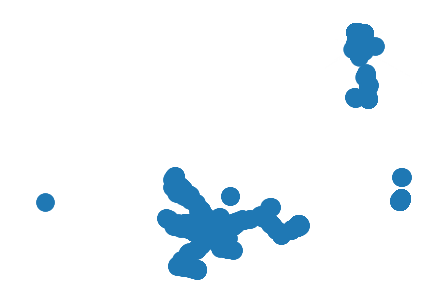

In [17]:
pos=dict()
for node in G.nodes:
    pos[node]=node
    
nx.draw(G, pos=pos)

In [ ]:
from pyproj import Transformer
import folium

m = folium.Map(location=[-22.983840,-43.211162], zoom_start=15)

transformer = Transformer.from_crs("EPSG:3857","EPSG:4326")

for node in G.nodes:
    folium.Marker(transformer.transform(*node)).add_to(m)
    
m

## Interpolate and Time Syncrhonize ##
Load the cleaned dataset for interpolation

In [4]:
df = dd.read_parquet('./../data/mobility/bus_data_clean.parquet', engine='pyarrow')
df.head()

,timestamp,order,line,latitude,longitude,speed
0,2019-01-25 00:03:05,0,0,-22.816891,-43.301788,0.0
1,2019-01-25 00:07:29,1,1,-22.874250,-43.357971,37.0
2,2019-01-25 00:07:59,1,1,-22.880329,-43.357670,37.0
3,2019-01-25 00:17:31,2,2,-22.858509,-43.348221,59.0
4,2019-01-25 00:19:26,3,3,-22.883600,-43.552929,0.0


In [5]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
